## Setup


In [1]:
!unzip models.zip

Archive:  models.zip
   creating: models/
   creating: models/lab3-model/
  inflating: models/lab3-model/keras_metadata.pb  
   creating: models/lab3-model/variables/
  inflating: models/lab3-model/variables/variables.data-00000-of-00001  
  inflating: models/lab3-model/variables/variables.index  
  inflating: models/lab3-model/saved_model.pb  
   creating: models/lab3-model/assets/


In [2]:
!pip3 install jmd-imagescraper

In [4]:
from jmd_imagescraper.core import *
from pathlib import Path

root = Path().cwd()/"images"


In [4]:
results_no = 1000 // 3

duckduckgo_search(root, "Chicken", "hong kong chicken", max_results=results_no)
duckduckgo_search(root, "Dumplings", "dumplings", max_results=results_no)
duckduckgo_search(root, "Salmon", "salmon", max_results=results_no)

Duckduckgo search: hong kong chicken


Duckduckgo search: dumplings


Duckduckgo search: salmon


Exception occured while retrieving https://tse4.mm.bing.net/th?id=OIP.ouxWCNXPxEpriwvq0GZJwQHaHa&pid=Api


[PosixPath('/content/images/Salmon/001_31fbcb66.jpg'),
 PosixPath('/content/images/Salmon/002_f1ce1a27.jpg'),
 PosixPath('/content/images/Salmon/003_6c73f240.jpg'),
 PosixPath('/content/images/Salmon/004_e1dbf557.jpg'),
 PosixPath('/content/images/Salmon/005_fcd274cc.jpg'),
 PosixPath('/content/images/Salmon/006_9ac2b979.jpg'),
 PosixPath('/content/images/Salmon/007_0bc6fffc.jpg'),
 PosixPath('/content/images/Salmon/008_abe850a4.jpg'),
 PosixPath('/content/images/Salmon/009_50d8f260.jpg'),
 PosixPath('/content/images/Salmon/010_d26ed8e2.jpg'),
 PosixPath('/content/images/Salmon/011_bda6f7bc.jpg'),
 PosixPath('/content/images/Salmon/012_12af06ff.jpg'),
 PosixPath('/content/images/Salmon/013_dcde80e6.jpg'),
 PosixPath('/content/images/Salmon/014_849c09ad.jpg'),
 PosixPath('/content/images/Salmon/015_e46e07c5.jpg'),
 PosixPath('/content/images/Salmon/016_ca1ea5cc.jpg'),
 PosixPath('/content/images/Salmon/017_de332b35.jpg'),
 PosixPath('/content/images/Salmon/018_a3a28aea.jpg'),
 PosixPath

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

from keras import layers
from keras import activations

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'bilinear'

def plot_accuracy(history):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    ax = plt.gca()
    ax.set_ylim([0.0, 1.0])
    plt.show()


def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    ax = plt.gca()
    ax.set_ylim([0.0, 2.5])
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def retrieve_history(name):
    np.load(f'history/{name}.npy', allow_pickle='TRUE').item()


def save_history(name, history):
    np.save(f'history/{name}.npy', history.history)


In [6]:
seed = 123

training = tf.keras.preprocessing.image_dataset_from_directory(
    root,
    batch_size=64,
    image_size=(32, 32),
    subset='training',
    label_mode='categorical',
    validation_split=.2,
    seed=seed
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    root,
    batch_size=64,
    image_size=(32, 32),
    subset='validation',
    validation_split=.2,
    label_mode='categorical',
    seed=seed
)

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=.9)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
metrics = [keras.metrics.CategoricalAccuracy()]

Found 998 files belonging to 3 classes.
Using 799 files for training.
Found 998 files belonging to 3 classes.
Using 199 files for validation.


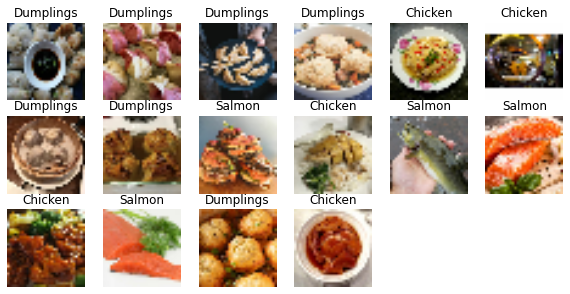

In [7]:
plt.figure(figsize=(10, 10))
class_names = training.class_names

def class_name(one_hot):
    for i, value in enumerate(one_hot):
        if value == 1:
            return class_names[i]

for images, labels in training.take(1):
    for i in range(16):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_name(labels[i]))
        plt.axis("off")

In [8]:
for images, labels in training.take(1):
    print(f'Images shape: {images.shape}')
    print(f'Labels shape: {labels.shape}')
    break

Images shape: (64, 32, 32, 3)
Labels shape: (64, 3)


In [9]:
print(training)

<BatchDataset shapes: ((None, 32, 32, 3), (None, 3)), types: (tf.float32, tf.float32)>


# Model from previous labs

In [7]:
def block(filters_no, dropout_rate, filter_size=(3, 3), pool_size=(8, 8), gap=False):
    layer_1 = layers.Conv2D(
        filters_no, filter_size,
        strides=1,
        padding='same',
        activation=activations.relu
    )
    layer_1_post = layers.BatchNormalization()
    layer_2 = layers.Conv2D(
        filters_no, filter_size,
        strides=1,
        padding='same',
        activation=activations.relu
    )

    if not gap:
        layer_3 = layers.MaxPooling2D(
            pool_size=pool_size,
            strides=pool_size,
            padding='same')
    else:
        layer_3 = layers.GlobalAvgPool2D()

    dropout_layer = layers.Dropout(dropout_rate)

    return [layer_1, layer_1_post, layer_2, layer_3, dropout_layer]

model = keras.Sequential([
    layers.Rescaling(scale=1./255.),
    *block(20, .1),
    *block(40, .2),
    *block(80, .3),
    *block(160, .4, gap=True),
    layers.Flatten(),
    layers.Dense(3, activation=activations.softmax)
])

model.build([64, 32, 32, 3])
model.summary()


model.compile(loss=loss_fn,optimizer=optimizer, metrics=metrics)
history = model.fit(training,
                    epochs=150,
                    validation_data=validation,
                    verbose=True)
save_history('lab3-model', history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (64, 32, 32, 3)           0         
_________________________________________________________________
conv2d_16 (Conv2D)           (64, 32, 32, 20)          560       
_________________________________________________________________
batch_normalization_8 (Batch (64, 32, 32, 20)          80        
_________________________________________________________________
conv2d_17 (Conv2D)           (64, 32, 32, 20)          3620      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (64, 4, 4, 20)            0         
_________________________________________________________________
dropout_8 (Dropout)          (64, 4, 4, 20)            0         
_________________________________________________________________
conv2d_18 (Conv2D)           (64, 4, 4, 40)           

2021-11-21 12:40:37.647435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


13/13 [==============================] - 2s 67ms/step - loss: 1.1156 - categorical_accuracy: 0.3655 - val_loss: 1.0987 - val_categorical_accuracy: 0.2864
Epoch 2/150
13/13 [==============================] - 1s 49ms/step - loss: 1.1202 - categorical_accuracy: 0.3454 - val_loss: 1.0987 - val_categorical_ac

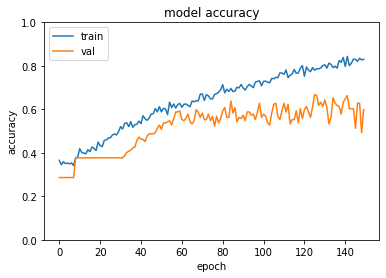

In [8]:
plot_accuracy(history)

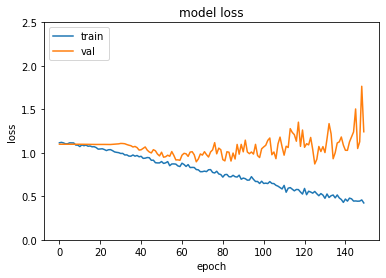

In [9]:
plot_loss(history)


In [13]:
base_model = keras.models.load_model('models/lab3-model')
base_model = keras.Model(base_model.input, outputs=base_model.layers[-2].output)
base_model.trainable = False

inputs = keras.Input(shape=(32, 32, 3))
x = inputs

x = base_model(x, training=False)
outputs = keras.layers.Dense(3, activation=activations.softmax)(x)
model = keras.Model(inputs, outputs)

model.build([64, 32, 32, 3])
model.summary()

model.compile(loss=loss_fn,optimizer=optimizer, metrics=metrics)
history = model.fit(training,
                    epochs=150,
                    validation_data=validation,
                    verbose=True)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_5 (Functional)         (None, 160)               459540    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 483       
Total params: 460,023
Trainable params: 483
Non-trainable params: 459,540
_________________________________________________________________
Epoch 1/150
13/13 [==============================] - 1s 46ms/step - loss: 1.2832 - categorical_accuracy: 0.4168 - val_loss: 1.1339 - val_categorical_accuracy: 0.4171

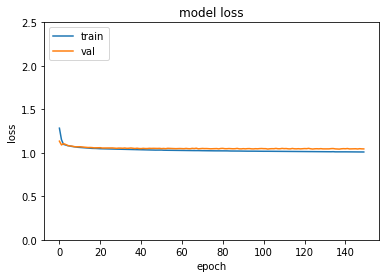

In [14]:
plot_loss(history)

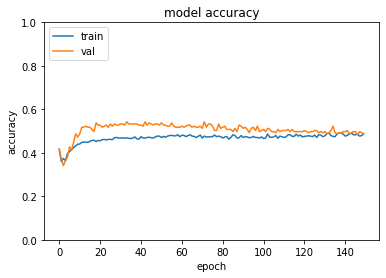

In [15]:
plot_accuracy(history)

# Transfer Learning - Xception

In [16]:
seed = 123

training = tf.keras.preprocessing.image_dataset_from_directory(
    root,
    batch_size=32,
    image_size=(256, 256),
    subset='training',
    label_mode='categorical',
    validation_split=.2,
    seed=seed
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    root,
    batch_size=32,
    image_size=(256, 256),
    subset='validation',
    validation_split=.2,
    label_mode='categorical',
    seed=seed
)

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=.9)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
metrics = [keras.metrics.CategoricalAccuracy()]

Found 998 files belonging to 3 classes.
Using 799 files for training.
Found 998 files belonging to 3 classes.
Using 199 files for validation.


In [17]:
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(256, 256, 3),
    include_top=False,
)

base_model.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = inputs
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(3, activation=activations.softmax)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
___________________________________________

In [18]:
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
history = model.fit(training,
                    epochs=30,
                    validation_data=validation,
                    verbose=True)
model.summary()
model.save('models/xception-imagenet')
save_history('xception-imagenet', history)

Epoch 1/30
25/25 [==============================] - 21s 626ms/step - loss: 1.0252 - categorical_accuracy: 0.4631 - val_loss: 0.8895 - val_categorical_accuracy: 0.6432
Epoch 2/30
25/25 [==============================] - 13s 494ms/step - loss: 0.8339 - categorical_accuracy: 0.6921 - val_loss: 0.7412 - val_categorical_accuracy: 0.7387
Epoch 3/30
25/25 [==============================] - 13s 500ms/step - loss: 0.7197 - categorical_accuracy: 0.7534 - val_loss: 0.6601 - val_categorical_accuracy: 0.7789
Epoch 4/30
25/25 [==============================] - 13s 496ms/step - loss: 0.6465 - categorical_accuracy: 0.7860 - val_loss: 0.6191 - val_categorical_accuracy: 0.8040
Epoch 5/30
25/25 [==============================] - 13s 503ms/step - loss: 0.6014 - categorical_accuracy: 0.7997 - val_loss: 0.5911 - val_categorical_accuracy: 0.8141
Epoch 6/30
25/25 [==============================] - 13s 498ms/step - loss: 0.5666 - categorical_accuracy: 0.8073 - val_loss: 0.5703 - val_categorical_accuracy: 0.809

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


FileNotFoundError: ignored

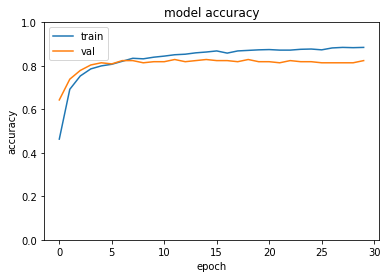

In [19]:
plot_accuracy(history)

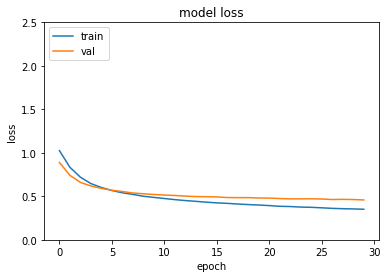

In [20]:
plot_loss(history)

## Fine-tuning

In [21]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-5, momentum=.9),  # Low learning rate
    loss=loss_fn,
    metrics=metrics,
)
history = model.fit(training,
                    epochs=15,
                    validation_data=validation,
                    verbose=True)

model.save('models/xception-imagenet-finetuned')
save_history('xception-imagenet-finetuned', history)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
__________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


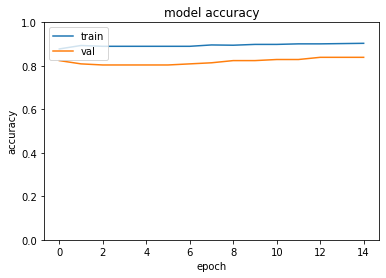

In [22]:
plot_accuracy(history)

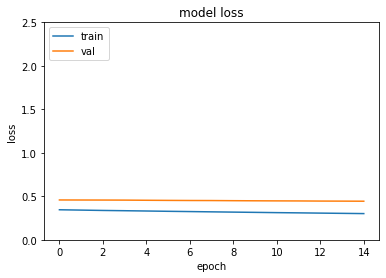

In [23]:
plot_loss(history)

## Decisions

In [26]:
input = keras.Input(shape=(256, 256, 3))
output = scale_layer(input)
act_output = base_model(output, training=False)
output = model.get_layer("global_average_pooling2d_2")(act_output)
pred_output = model.get_layer("dense_3")(output)
modell = keras.Model(input, outputs=[act_output, pred_output], trainable=False)
modell.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 0
Non-trainable params: 20,867,627
_______________________________________________

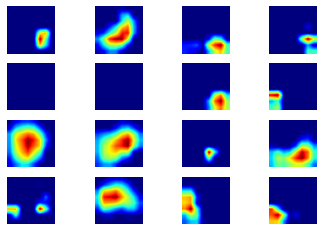

<Figure size 1296x1296 with 0 Axes>

In [28]:
#%%
from tensorflow import convert_to_tensor

from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array

def load_image(image_path):
  image = load_img(image_path)
  numpy_data = img_to_array(image)

  img = convert_to_tensor(numpy_data)
  img = tf.image.resize(img, size=tf.constant([256, 256]))

  return img

def predict_class(img):
  q = modell.predict(np.array([img]))[1][0]
  print(q)
  return tf.argmax(q)

def scale_image(img):
  return scale_layer(img)

def base_model_activation(img):
  img = scale_image(img)
  img = tf.reshape(img, [1, 256, 256, 3])
  return base_model.predict(img)

def predict(img):
  img = tf.reshape(img, [1, 256, 256, 3])
  return modell.predict(img)

def plot_couple_activations(img):
  activation, _ = predict(img)
  transposed_result = tf.transpose(activation, [0, 3, 1, 2])
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    r = transposed_result.numpy()[0, i]
    plt.imshow(r)
    plt.axis("off")
  
  plt.figure(figsize=(18, 18))
  plt.show()

test_img = load_image('images/Chicken/006_4fccfeeb.jpg')
plot_couple_activations(test_img)

In [72]:
from scipy.ndimage import zoom

scale = 256 / 8
figsize = (9, 9)

def calc_heatmap(activ, pred):
  predicted_class = np.argmax(pred, axis=1).squeeze()
  w, b = modell.get_layer("dense_3").weights
  weights = w[:, predicted_class].numpy()
  heatmap = activ.squeeze() @ weights

  return heatmap

def show_activations(img):
  activ, pred = predict(img)
  plt.figure(figsize=figsize)
  for i in range(16):
      plt.subplot(4, 4, i + 1)
      plt.imshow(img / 255.)
      x = zoom(activ[0, :,:, i], zoom=(scale, scale))
      plt.imshow(zoom(activ[0, :,:, i], zoom=(scale, scale)), alpha=.4)

  plt.show()

def show_heatmap(img):
  activ, pred = predict(img)
  heatmap = calc_heatmap(activ, pred)
  plt.figure(figsize=figsize)
  plt.title(f'{pred.squeeze()}', fontsize=11)
  plt.imshow(img / 255.)
  plt.imshow(zoom(heatmap, zoom=(scale, scale)), alpha=0.3)

def show_heatmaps(imgs, per_class_size=4):
  np.set_printoptions(precision=3)
  plt.figure(figsize=figsize)
  for i in range(3 * per_class_size):
    img = imgs[i]
    activ, pred = predict(img)
    heatmap = calc_heatmap(activ, pred)
    predicted = np.argmax(pred.squeeze())
    plt.subplot(3, per_class_size, i + 1)
    # plt.suptitle(f'Predicted: {class_names[predicted]}, probabilities: {pred.squeeze()}, actual: {class_names[i // per_class_size]}')
    plt.title(f'{pred.squeeze()}', fontsize=11)
    plt.imshow(img / 255.)
    plt.imshow(zoom(heatmap, zoom=(scale, scale)), alpha=0.3)
  
  plt.show()


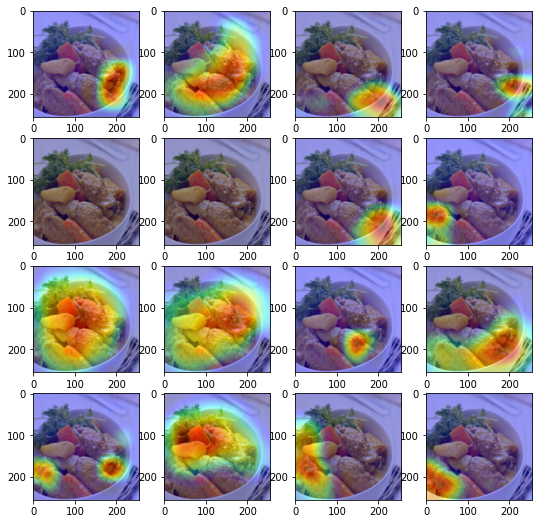

In [30]:
show_activations(test_img)

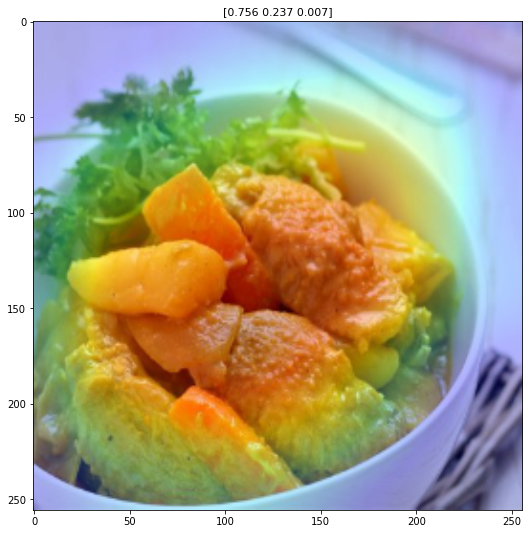

In [73]:
show_heatmap(test_img)

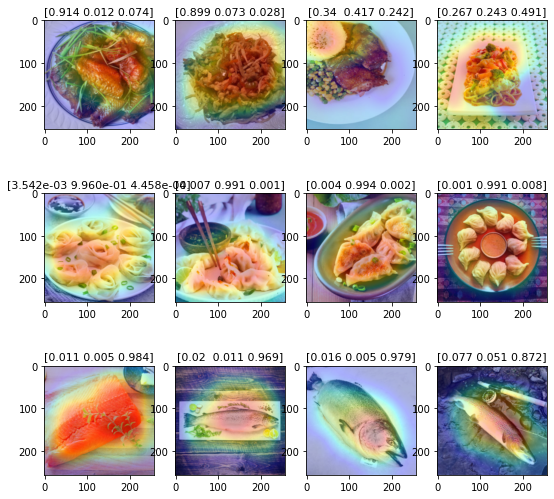

In [71]:
c1 = load_image('images/Chicken/001_132b3eb4.jpg')
c2 = load_image('images/Chicken/002_896e72af.jpg')
c3 = load_image('images/Chicken/003_fa04d85d.jpg')
c4 = load_image('images/Chicken/004_673ae1b7.jpg')

d1 = load_image('images/Dumplings/001_1081b776.jpg')
d2 = load_image('images/Dumplings/002_33372c6f.jpg')
d3 = load_image('images/Dumplings/003_ec5c1b22.jpg')
d4 = load_image('images/Dumplings/004_7637897b.jpg')

s1 = load_image('images/Salmon/001_31fbcb66.jpg')
s2 = load_image('images/Salmon/002_f1ce1a27.jpg')
s3 = load_image('images/Salmon/003_6c73f240.jpg')
s4 = load_image('images/Salmon/004_e1dbf557.jpg')

imgs = [c1, c2, c3, c4, d1, d2, d3, d4, s1, s2, s3, s4]
show_heatmaps(imgs, 4)

## Finding incorrectly classified images

In [124]:
total_labels = []
total_imgs = []
for element in validation.as_numpy_iterator(): 
  total_imgs.append(element[0])
  total_labels.append(np.argmax(element[1], axis=1))

total_labels = np.concatenate(total_labels)
total_imgs = np.concatenate(total_imgs)

In [125]:
predictions = model.predict(total_imgs)
predictions = np.argmax(predictions, axis=1)
predictions.shape

(199,)

In [126]:
wrong_predictions = total_imgs[predictions != total_labels]
wrong_predictions.shape

(32, 256, 256, 3)

(256, 256, 3)


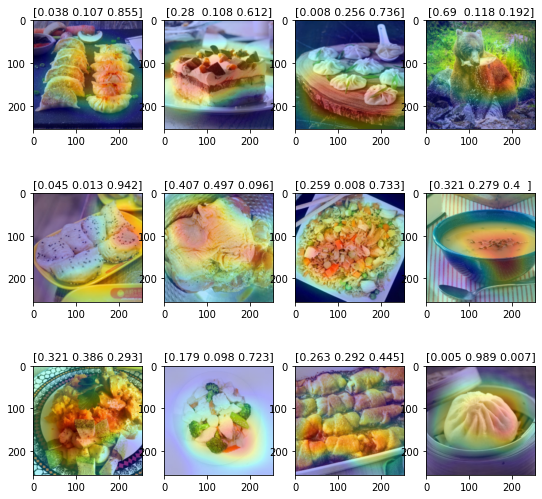

In [132]:
subset = wrong_predictions[:12, :, :, :]
show_heatmaps(subset, 4)

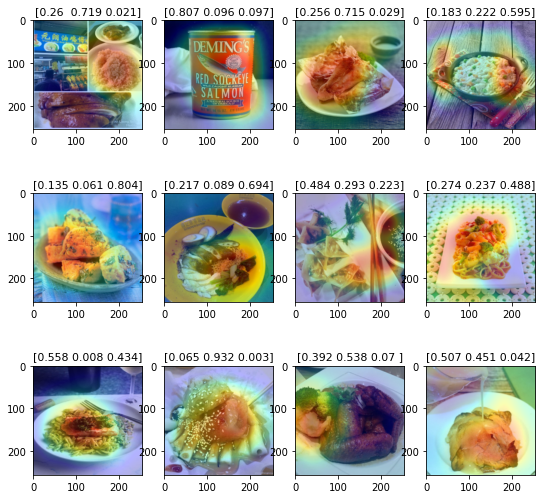

In [133]:
subset = wrong_predictions[12:24, :, :, :]
show_heatmaps(subset, 4)

In [74]:
!zip -r lab5.zip .

  adding: .config/ (stored 0%)
  adding: .config/.last_opt_in_prompt.yaml (stored 0%)
  adding: .config/configurations/ (stored 0%)
  adding: .config/configurations/config_default (deflated 15%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/gce (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/.last_update_check.json (deflated 24%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2021.11.18/ (stored 0%)
  adding: .config/logs/2021.11.18/14.35.09.738473.log (deflated 53%)
  adding: .config/logs/2021.11.18/14.35.36.918574.log (deflated 53%)
  adding: .config/logs/2021.11.18/14.35.57.849518.log (deflated 54%)
  adding: .config/logs/2021.11.18/14.34.49.152157.log (deflated 91%)
  adding: .config/logs/2021.11.18/14.35.29.959577.log (deflated 86%)
  adding: .config/logs/2021.11.18/14.35.58.667492.log (deflated 53%)
  adding: images/ (stored 0%)
  adding: images/Dumplings/ (stored 0%)
  

## 6. Done!
